In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sgimc.utils import make_imc_data, sparsify, sparsify_with_mask

from sgimc import IMCProblem

from sgimc.qa_objective import QAObjectiveL2Loss
from sgimc.qa_objective import QAObjectiveLogLoss
from sgimc.qa_objective import QAObjectiveHuberLoss

from sgimc.algorithm.admm import sub_0_cg
from sgimc.algorithm.admm import sub_0_lbfgs
from sgimc.algorithm.admm import sub_m

from sgimc import imc_descent
from sgimc.utils import performance

from sgimc.utils import plot_WH, plot_loss

from utils import calculate_loss, invert


PROBLEM = "classification" if False else "regression"
random_state = np.random.RandomState(0x0BADCAFE)

In [2]:
from sgimc.algorithm import admm_step
from sgimc.algorithm.decoupled import step as decoupled_step

def step_qaadmm(problem, W, H, C, eta, method="l-bfgs", sparse=True,
                n_iterations=50, rtol=1e-5, atol=1e-8):

    approx_type = "quadratic" if method in ("cg", "tron",) else "linear"
    Obj = problem.objective(W, H, approx_type=approx_type)

    return admm_step(Obj, W, C, eta, sparse=sparse, method=method,
                     n_iterations=n_iterations, rtol=rtol, atol=atol)

def step_decoupled(problem, W, H, C, eta, rtol=1e-5, atol=1e-8):

    Obj = problem.objective(W, H, approx_type="linear")

    return decoupled_step(Obj, W, C, eta, rtol=rtol, atol=atol)

In [3]:
step_fn = step_qaadmm
# step_fn = step_decoupled

if PROBLEM == "classification":
    QAObjectiveLoss = QAObjectiveLogLoss
else:
    QAObjectiveLoss = QAObjectiveL2Loss  # QAObjectiveHuberLoss

In [4]:
if PROBLEM == "classification":
    C = 1e0, 1e-1, 1e-3
    eta = 1e0
else:
    # C = 2e-5, 2e-3, 0
    C = 2e-3, 2e-4, 1e-4
    eta = 1e1
    
step_kwargs = {
    "C": C,                 # the regularizr constants (C_lasso, C_group, C_ridge)
    "eta": eta,             # the eta of the ADMM (larger - faster but more unstable)
    "rtol": 1e-5,           # the relative tolerance for stopping the ADMM
    "atol": 1e-8,           # the absolute tolerance
    "method": "cg",         # the method to use in Sub_0
    "n_iterations": 2,      # the number of iterations of the inner ADMM
}

n_samples, n_objects = 800, 1600
n_rank = 25
n_features = 50

scale = 0.05
noise = 0.10

n_iter = 100

## Data creation

In [ ]:
for i, elem in enumerate(elements):
    X, W_ideal, Y, H_ideal, R_noisy_full, R_clean_full = make_imc_data(
        n_samples, n_features, n_objects, n_features,
        n_rank, scale=(scale, scale), noise=scale*noise,
        binarize=(PROBLEM == "classification"),
        random_state=random_state,
        return_noisy_only=False)

    _, mask = sparsify(R_noisy_full, elem, random_state=random_state)
    
    np.save(exp_path + "R_noisy_{}.npy".format(i), R_noisy_full)
    np.save(exp_path + "R_clean_{}.npy".format(i), R_clean_full)
    np.save(exp_path + "X_{}.npy".format(i), X)
    np.save(exp_path + "Y_{}.npy".format(i), Y)
    np.save(exp_path + "mask_{}.npy".format(i), mask)

## Parameter to vary

In [6]:
elements = np.arange(0.001, 0.05, 0.0005)
elem_short = elements[::3]

## K < n_rank

In [6]:
K = 20

In [7]:
exp_path = "/nmnt/x04-hdd/boris_temp/SGIMC_IMC/article_instances/"

losses = []
for i, elem in enumerate(elements):
    R_noisy_full = np.load(exp_path + "R_noisy_{}.npy".format(i))
    R_clean_full = np.load(exp_path + "R_clean_{}.npy".format(i))
    X = np.load(exp_path + "X_{}.npy".format(i))
    Y = np.load(exp_path + "Y_{}.npy".format(i))
    mask = np.load(exp_path + "mask_{}.npy".format(i))

    R_train, mask = sparsify(R_noisy_full, elem, random_state=random_state)
    problem = IMCProblem(QAObjectiveLoss, X, Y, R_train, n_threads=8)

    W_0 = random_state.normal(size=(X.shape[1], K))
    H_0 = random_state.normal(size=(Y.shape[1], K))

    W, H = W_0.copy(), H_0.copy()

    W, H = imc_descent(problem, W, H,
                       step_fn,                  # the inner optimization
                       step_kwargs=step_kwargs,  # asrtguments for the inner optimizer
                       n_iterations=n_iter,      # the number of outer iterations (Gauss-Siedel)
                       n_init_iterations=0,
                       return_history=True,      # Record the evolution of the matrices (W, H)
                       rtol=1e-5,                # relative stopping tolerance for the outer iterations
                       atol=1e-7,                # absolute tolerance
                       verbose=False,            # show the progress bar
                       check_product=True,       # use the product W H' for stopping
                      )

    losses.append(calculate_loss(R_clean_full, X, W, H, Y, invert(mask)))
    
losses = np.array(losses)
np.save(exp_path + "results_sgimc.npy", losses)

## K >= n_rank 

In [8]:
K = 30

In [9]:
exp_path = "/nmnt/x04-hdd/boris_temp/SGIMC_IMC/article_instances/"

losses = []
for i, elem in enumerate(elements):
    R_noisy_full = np.load(exp_path + "R_noisy_{}.npy".format(i))
    R_clean_full = np.load(exp_path + "R_clean_{}.npy".format(i))
    X = np.load(exp_path + "X_{}.npy".format(i))
    Y = np.load(exp_path + "Y_{}.npy".format(i))
    mask = np.load(exp_path + "mask_{}.npy".format(i))

    R_train = sparsify_with_mask(R_noisy_full, mask)
    problem = IMCProblem(QAObjectiveLoss, X, Y, R_train, n_threads=8)

    W_0 = random_state.normal(size=(X.shape[1], K))
    H_0 = random_state.normal(size=(Y.shape[1], K))

    W, H = W_0.copy(), H_0.copy()

    W, H = imc_descent(problem, W, H,
                       step_fn,                  # the inner optimization
                       step_kwargs=step_kwargs,  # asrtguments for the inner optimizer
                       n_iterations=n_iter,      # the number of outer iterations (Gauss-Siedel)
                       n_init_iterations=0,
                       return_history=True,      # Record the evolution of the matrices (W, H)
                       rtol=1e-5,                # relative stopping tolerance for the outer iterations
                       atol=1e-7,                # absolute tolerance
                       verbose=False,            # show the progress bar
                       check_product=True,       # use the product W H' for stopping
                      )

    losses.append(calculate_loss(R_clean_full, X, W, H, Y, invert(mask)))
    
losses = np.array(losses)
np.save(exp_path + "results_sgimc_1.npy", losses)

## Evaluation

[]

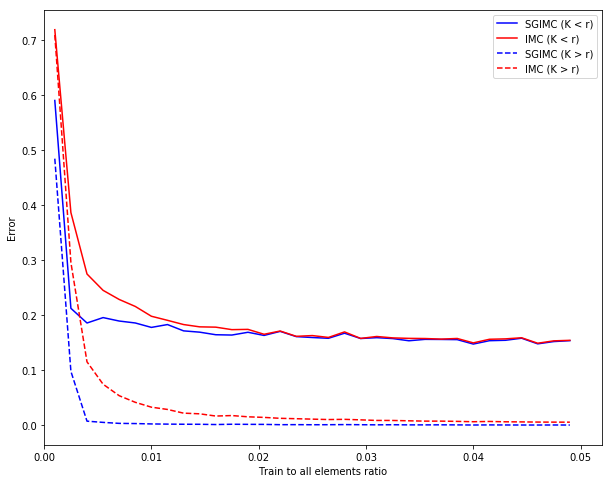

In [9]:
exp_path = "/nmnt/x04-hdd/boris_temp/SGIMC_IMC/article_instances/"

sgimc_losses = np.load(exp_path + "results_sgimc.npy")
imc_losses = np.load(exp_path + "results_imc.npy")

sgimc_losses_1 = np.load(exp_path + "results_sgimc_1.npy")
imc_losses_1 = np.load(exp_path + "results_imc_1.npy")


plt.figure(figsize=(10,8))
plt.plot(elem_short, sgimc_losses[::3], 'b-', label='SGIMC (K < r)')
plt.plot(elem_short, imc_losses, 'r-', label='IMC (K < r)')

plt.plot(elem_short, sgimc_losses_1[::3], 'b--', label='SGIMC (K > r)')
plt.plot(elem_short, imc_losses_1, 'r--', label='IMC (K > r)')

plt.xlim((0,0.052))
#plt.ylim((0,1))

plt.xlabel('Train to all elements ratio')
plt.ylabel('Error')
plt.legend()

plt.plot()